<a href="https://colab.research.google.com/github/MonkeyWrenchGang/2024_BAN7040/blob/main/17July2024_Forests_and_Tuning_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What is Churn?
---

Churn, also known as customer attrition, refers to the phenomenon when customers or subscribers stop using a company's products or services during a certain time frame.

The rate at which customers leave is a critical metric for many businesses, especially those operating on a subscription-based model, such as telecoms, internet service providers, and SaaS (Software as a Service) companies.

## Why Does Churn Matter?

Churn directly impacts a company's revenue and growth prospects. High churn rates can indicate customer dissatisfaction, ineffective customer engagement, or stronger offerings by competitors. By understanding and analyzing churn, companies can:

- Identify the root causes leading to customer departure.
- Develop strategies to improve customer retention.
- Tailor products, services, and marketing efforts to meet customer needs better.
- Enhance customer satisfaction and loyalty, leading to higher lifetime value.

### Addressing Churn

To effectively address churn, companies typically undergo several steps:

1. **Data Collection**: Gather data on customer interactions, satisfaction, service usage.


2. **Predictive Modeling**: a ML model  predictive models to PREDICT which customers are at a high risk of churning. Commonly used models include logistic regression, decision trees, random forests, and gradient boosting machines.

3. **Intervention Strategies**: Based on the insights gained from data analysis and predictive modeling, implement targeted interventions to retain high-risk customers. These strategies could include personalized offers, product improvements, proactive customer service, and loyalty programs.



### Example Dataset: Churn_training.csv

About the data:

- **Customer Demographics**: Age, gender, tenure with the company, etc.
- **Service Usage**: Details about how the customer uses the service, including usage levels, service plans, and features.
- **Billing Information**: Payment methods, billing cycles, and any history of late payments.
- **Customer Feedback**: Satisfaction scores, complaints, and reasons for contacting customer service.


In [ ]:

import warnings
warnings.filterwarnings('ignore')

# -- pandas and numpy --
import numpy as np
import pandas as pd

# -- plotting --
import matplotlib.pyplot as plt
import seaborn as sns

# -- sklearn stuff --

# -- sklearn modules
from sklearn.model_selection import train_test_split   #- partition train/test split
from sklearn.ensemble import RandomForestClassifier    #- random forest classifier

# -- we need these to make our pipelines
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV # NOTE...
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

# -- we need these to evaluate our models
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# -- need this to render charts in notebook --
%matplotlib inline

## Stage


In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/MonkeyWrenchGang/2024_BAN7040/main/Churn_training.csv")
df = df.sample(frac=0.1).reset_index(drop=True)
df.head(5)

,monthly_minutes,customer_service_calls,streaming_minutes,total_billed,prev_balance,late_payments,ip_address_asn,phone_area_code,customer_reg_date,email_domain,...,currency_code,maling_code,paperless_billing,payment_method,customer_id,billing_address,gender,network_speed,senior_citizen,churn
0,16428.0,2.0,17037.0,211.0,73.0,5.0,58210.0,253.0,2019-11-11,gmail.com,...,cad,S,No,Mailed Check,1-86816-154-4.63698,9217 Bond Row Suite 924,Male,5G,0.0,0
1,24428.0,1.0,18014.0,258.0,43.0,4.0,21736.0,255.0,2019-11-16,yahoo.com,...,cad,X,Yes,Electronic Check,0-369-96949-9.57777,415 Harris Points,Female,5G,0.0,0
2,17898.0,1.0,14307.0,193.0,35.0,5.0,11848.0,239.0,2020-05-20,gmail.com,...,eur,W,Yes,Mailed Check,1-4743-8227-4.61336,8315 Melanie Squares Apt. 844,Male,5G,0.0,0
3,24267.0,2.0,9472.0,219.0,51.0,4.0,14132.0,259.0,2020-04-12,gmail.com,...,cad,A,No,Mailed Check,0-05-373282-0.18994,1545 Booker Crescent Apt. 343,Female,4Glte,1.0,0
4,11440.0,1.0,32141.0,330.0,53.0,3.0,49313.0,244.0,2019-10-26,gmail.com,...,cad,C,Yes,Electronic Check,1-74248-152-3.97932,1272 Thomas Mission,Male,5G,1.0,0


## 2. Clean up Column Names
It's just not fun dealing with ill-formed columns

- remove leading and trailing characters
- replace spaces with underscores _
- change case to lower case
- remove various special characters

In [ ]:
df.columns = ( df.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
    .str.replace('-', '_')
    .str.replace('(', '')
    .str.replace(')', '')
    .str.replace('?', '')
    .str.replace('\'', '') # notice the backslash \ this is an escape character
)
print(df.columns)

Index(['monthly_minutes', 'customer_service_calls', 'streaming_minutes',
       'total_billed', 'prev_balance', 'late_payments', 'ip_address_asn',
       'phone_area_code', 'customer_reg_date', 'email_domain', 'phone_model',
       'billing_city', 'billing_postal', 'billing_state', 'partner',
       'phone_service', 'multiple_lines', 'streaming_plan', 'mobile_hotspot',
       'wifi_calling_text', 'online_backup', 'device_protection',
       'number_phones', 'contract_code', 'currency_code', 'maling_code',
       'paperless_billing', 'payment_method', 'customer_id', 'billing_address',
       'gender', 'network_speed', 'senior_citizen', 'churn'],
      dtype='object')


## Basic Decision

In [ ]:
def df_profile(df, target):

    df = df.copy()

    numeric_features = [ c for c in df.select_dtypes(include = np.number).columns ]

    categorical_features = [ c for c in df.select_dtypes(include = np.object).columns ]

    rowcnt = len(df)
    df_s1  = df.agg(['count', 'nunique','mean','min','max']).transpose().reset_index().rename(columns={"index":"feature_name"}).round(4)
    df_s1['count'] = df_s1['count'].astype('int64')
    df_s1['nunique'] = df_s1['nunique'].astype('int64')
    df_s1["null"] = (rowcnt - df_s1["count"]).astype('int64')
    df_s1["not_null"] = rowcnt - df_s1["null"]
    df_s1["null_pct"] = df_s1["null"] / rowcnt
    df_s1["nunique_pct"] = df_s1['nunique'] / rowcnt
    dt = pd.DataFrame(df.dtypes).reset_index().rename(columns={"index":"feature_name", 0:"dtype"})
    df_stats = pd.merge(dt, df_s1, on='feature_name', how='inner')

    df_stats = df_stats.sort_values("dtype").reset_index(drop=True)
    # -- part 2
    df_stats['feature_type'] = "UNKOWN"
    df_stats.loc[df_stats["dtype"] == object, 'feature_type'] = "CATEGORY"
    df_stats.loc[(df_stats["dtype"] == "int64") | (df_stats["dtype"] == "float64"), 'feature_type'] = "NUMERIC"
    # df_stats.loc[df_stats["dtype"] == "float64", 'feature_type'] = "NUMERIC"
    df_stats.loc[df_stats["feature_name"] == target, 'feature_type'] = "TARGET"


    # -- part 3
    df_stats['feature_warning'] = "NO WARNING"
    df_stats.loc[df_stats["nunique_pct"] > 0.7,'feature_warning' ] = "EXCLUDE, GT 70% UNIQUE"
    df_stats.loc[(df_stats["null_pct"] > 0.2) & (df_stats["null_pct"] <= 0.5), 'feature_warning' ] = "NULL WARNING, GT 20% MISSING"
    df_stats.loc[df_stats["null_pct"] > 0.5,'feature_warning' ] = "EXCLUDE, GT 50% MISSING"
    df_stats.loc[((df_stats['dtype'] == "int64" ) | (df_stats['dtype'] == "float64" ) ) & (df_stats['nunique'] < 0.2), 'feature_warning' ] = "LIKELY CATEGORICAL, NUMERIC w. LOW CARDINALITY"

    return df_stats

df_profile(df, "churn")

,feature_name,dtype,count,nunique,mean,min,max,null,not_null,null_pct,nunique_pct,feature_type,feature_warning
0,churn,int64,9090,2,0.056436,0.0,1.0,0,9090,0.00000,0.000220,TARGET,NO WARNING
1,number_phones,float64,9086,9,5.313559,1.0,9.0,4,9086,0.00044,0.000990,NUMERIC,NO WARNING
2,senior_citizen,float64,9088,2,0.502861,0.0,1.0,2,9088,0.00022,0.000220,NUMERIC,NO WARNING
3,billing_postal,float64,9085,5142,49735.098404,527.0,99922.0,5,9085,0.00055,0.565677,NUMERIC,NO WARNING
4,phone_area_code,float64,9087,74,247.427314,212.0,289.0,3,9087,0.00033,0.008141,NUMERIC,NO WARNING
5,ip_address_asn,float64,9088,5385,34830.182879,4260.0,64935.0,2,9088,0.00022,0.592409,NUMERIC,NO WARNING
6,monthly_minutes,float64,9085,7209,19854.380517,1024.0,37268.0,5,9085,0.00055,0.793069,NUMERIC,"EXCLUDE, GT 70% UNIQUE"
7,prev_balance,float64,9086,79,51.456747,16.0,99.0,4,9086,0.00044,0.008691,NUMERIC,NO WARNING
8,total_billed,float64,9088,225,250.355414,128.0,381.0,2,9088,0.00022,0.024752,NUMERIC,NO WARNING
9,streaming_minutes,float64,9088,7124,20734.763974,3304.0,40526.0,2,9088,0.00022,0.783718,NUMERIC,"EXCLUDE, GT 70% UNIQUE"


In [ ]:
# 1. Split features into categorical and numerical features
target = 'churn'

numeric_features = ['number_phones',
                    "late_payments",
                    "customer_service_calls",
                    "total_billed"]

categorical_features = ["phone_model"]

feature_names = numeric_features + categorical_features

# train test split

In [ ]:
# Separate the features and the target variable
X = df.drop('churn', axis=1)
y = df['churn']  # Target variable column name

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X[feature_names], y, test_size=0.3, random_state=42)

print(f"X_train % : {X_train.shape[0]/df.shape[0]:.2%}")
print(f"X_test  % : {X_test.shape[0]/df.shape[0]:.2%}")

X_train % : 70.00%
X_test  % : 30.00%


# Create Pipeline Preprocessor
---

simple imputer default value


In [ ]:
# Create the preprocessing pipelines
numerical_transformer = SimpleImputer(strategy='mean')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='UNK')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])




# Baseline Fit Random Forest

In [ ]:
# Initialize the pipeline with the preprocessor and a Random Forest classifier
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(n_estimators=10,
                                                                    max_depth=10,
                                                                    n_jobs=-1,
                                                                    random_state=42))])
# Train the pipeline
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  ['number_phones',
                                                   'late_payments',
                                                   'customer_service_calls',
                                                   'total_billed']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='UNK',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['phone_model'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=10, n_estimators=10,
                                        n_jobs=-1, random_state=42))])

In [ ]:
# Predictions
y_pred_rf = rf_pipeline.predict(X_test)
y_pred_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

# Evaluation Metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)

# Print the metrics
print("Random Forest Model Evaluation:")
print(f"  Accuracy: {accuracy_rf:.4f}")
print(f"  AUC: {auc_rf:.4f}")
print(f"  Precision: {precision_rf:.4f}")
print(f"  Recall: {recall_rf:.4f}")


Random Forest Model Evaluation:
  Accuracy: 0.9498
  AUC: 0.8499
  Precision: 0.7381
  Recall: 0.1975


In [ ]:
# Create the parameter grid
param_grid = {
    'classifier__n_estimators': [20, 30, 50],
    #'classifier__max_depth': [None, 5, 10],
    'classifier__min_samples_split': [ 5, 10],
    #'classifier__min_samples_leaf': [1, 2, 4]
}

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(rf_pipeline, param_grid, cv=3, n_jobs=-1, scoring='roc_auc', verbose=1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best set of hyperparameters
best_params = grid_search.best_params_

# Print the best set of hyperparameters
print("Best parameters:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters:
  classifier__min_samples_split: 10
  classifier__n_estimators: 50


# Results of CV

In [ ]:
cv_results_df = pd.DataFrame(grid_search.cv_results_)
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__min_samples_split,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.214884,0.002439,0.045993,0.008048,5,20,"{'classifier__min_samples_split': 5, 'classifi...",0.828321,0.849287,0.791375,0.822994,0.023941,6
1,0.416852,0.120393,0.103417,0.011616,5,30,"{'classifier__min_samples_split': 5, 'classifi...",0.829402,0.852840,0.800947,0.827730,0.021218,5
2,1.308396,0.077453,0.118456,0.023066,5,50,"{'classifier__min_samples_split': 5, 'classifi...",0.827369,0.864868,0.811533,0.834590,0.022365,2
3,0.551623,0.111451,0.119354,0.025324,10,20,"{'classifier__min_samples_split': 10, 'classif...",0.829994,0.865569,0.801392,0.832319,0.026252,4
4,0.674818,0.109572,0.105652,0.018703,10,30,"{'classifier__min_samples_split': 10, 'classif...",0.830064,0.865943,0.804838,0.833615,0.025072,3
5,0.832734,0.066926,0.114841,0.021865,10,50,"{'classifier__min_samples_split': 10, 'classif...",0.831881,0.870195,0.808311,0.836796,0.025502,1


# Graph

<Axes: xlabel='param_classifier__n_estimators', ylabel='mean_test_score'>

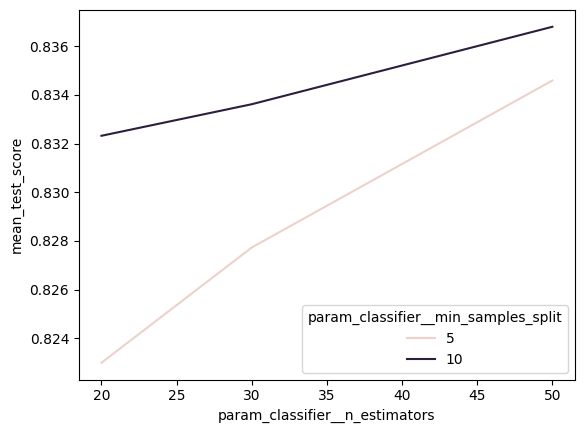

In [ ]:
sns.lineplot(data=cv_results_df, x='param_classifier__n_estimators', y='mean_test_score', hue='param_classifier__min_samples_split')

In [ ]:
best_params

{'classifier__min_samples_split': 10, 'classifier__n_estimators': 50}

# Refit with Best Parameters

In [ ]:
# Initialize the pipeline with the preprocessor and a Random Forest classifier
rf_pipeline_hpo = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(n_estimators=50,
                                                                    min_samples_split=10,
                                                                    max_depth = 10,
                                                                    n_jobs=-1,
                                                                    random_state=42))])
# Train the pipeline
rf_pipeline_hpo.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  ['number_phones',
                                                   'late_payments',
                                                   'customer_service_calls',
                                                   'total_billed']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='UNK',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['phone_model'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=10, min_samples_split=10,
                                        n_estimators=50, n_jobs=-1,
                                        random_state=42))])

In [ ]:
# compare rf_pipeline to rf_pipeline_hpo performance
y_pred_rf = rf_pipeline.predict(X_test)
y_pred_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]
y_pred_rf_hpo = rf_pipeline_hpo.predict(X_test)
y_pred_proba_rf_hpo = rf_pipeline_hpo.predict_proba(X_test)[:, 1]

# Evaluation Metrics
print("Random Forest Model Evaluation:")
print(f"  Accuracy: {accuracy_rf:.4f}")
print(f"  AUC: {auc_rf:.4f}")
print(f"  Precision: {precision_rf:.4f}")
print("\n -------- \n")
print("Random Forest Model Evaluation with HPO:")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_rf_hpo):.4f}")
print(f"  AUC: {roc_auc_score(y_test, y_pred_proba_rf_hpo):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_rf_hpo):.4f}")

Random Forest Model Evaluation:
  Accuracy: 0.9498
  AUC: 0.8499
  Precision: 0.7381

 -------- 

Random Forest Model Evaluation with HPO:
  Accuracy: 0.9490
  AUC: 0.8480
  Precision: 0.7647
